In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler


import os
#import PIL
#from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
print('THIS IS A GLOBAL VARIABLE. Do not change testeq_GW')
global testeq_GW
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')

THIS IS A GLOBAL VARIABLE. Do not change testeq_GW


# write function and initialize PEI

In [3]:
#PEI code
pei_ratheatmap=pd.read_csv("/project/hshadman/hshadman/caleb_cyu1/jupyter_nb/pei_Rg_Ree_master_out.csv")
pei_ratheatmap['ratio']=pei_ratheatmap.Ree.values**2/pei_ratheatmap.Rg.values**2

test=pei_ratheatmap.copy()

temp_rg_mean=[]
for sim in test.proton.unique():
    temp_rg_mean.append(list(np.repeat(test[test.proton==sim]['Rg'].mean(),
                                 test[test.proton==sim]['Rg'].shape[0])))
    
test['Rg_mean']=list(chain.from_iterable(temp_rg_mean))
test['Rg/Rg_mean']=test['Rg'].values/test['Rg_mean']

pei_ratheatmap=test.copy()
del test, temp_rg_mean

In [6]:
def get_grid_pei(pei_ratheatmap_input):
    example_protein_dir = pei_ratheatmap_input.copy()
    protein_rg2 = pei_ratheatmap_input.Rg.values**2
    protein_ree2 = pei_ratheatmap_input.Ree.values**2
    protein_ratio = protein_ree2/protein_rg2
    protein_rg_by_rg_mean = pei_ratheatmap_input['Rg/Rg_mean'].values
    global grid_protein,grid_GW
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    x_total.append(protein_rg_by_rg_mean)
    y_total.append(protein_ratio)
    
    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    step_x=0.3#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=3#(
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x+1)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y+1)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])
#    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])
    return

In [7]:
def compile_umap_df(pei_ratheatmap_all):
    j=0
    for proton_state in pei_ratheatmap_all.proton.unique():
        if j==0:
            get_grid_pei(pei_ratheatmap_all[pei_ratheatmap_all.proton==proton_state])
            current_df = pd.DataFrame(grid_protein.flatten()).T
            current_df.columns=[f'box{box_lab}' for box_lab in range(grid_protein.flatten().shape[0])]
            current_df.insert(0,'proton',proton_state)
            master_df = current_df.copy()
        else:
            get_grid_pei(pei_ratheatmap_all[pei_ratheatmap_all.proton==proton_state])
            current_df = pd.DataFrame(grid_protein.flatten()).T
            current_df.columns=[f'box{box_lab}' for box_lab in range(grid_protein.flatten().shape[0])]
            current_df.insert(0,'proton',proton_state)
            master_df = pd.concat([master_df,current_df]).copy()
        j+=1
    return master_df

# get 2d conformation shape plot at different nu values (run in order, see j value in each cell) (ALL ~28000 sequences)

In [8]:
%%time


master_df = compile_umap_df(pei_ratheatmap).copy()

CPU times: user 1.61 s, sys: 76.6 ms, total: 1.69 s
Wall time: 1.7 s


In [10]:

master_df = master_df.reset_index(drop=True)
master_df

,proton,box0,box1,box2,box3,box4,box5,box6,box7,box8,...,box90,box91,box92,box93,box94,box95,box96,box97,box98,box99
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# separate X and y


In [13]:
X = master_df[master_df.columns[master_df.columns.str.contains('box')]]
y = master_df['proton']

# Run Regressor models

## Random Forest regressor 25% test size

In [14]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

In [15]:
print('fixed seed here')
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

fixed seed here


In [16]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (6, 100)
Training Labels Shape: (6,)
Testing Features Shape: (3, 100)
Testing Labels Shape: (3,)


In [17]:
from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);

In [18]:
predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 3.04
MSE: 13.47


## predicted vs actual values for test dataset


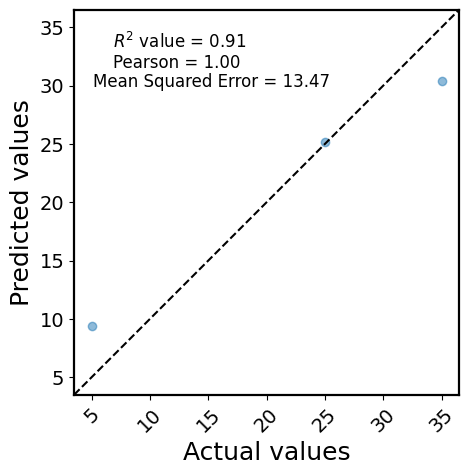

In [19]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## double-check what predicted vs actual looks like for training dataset

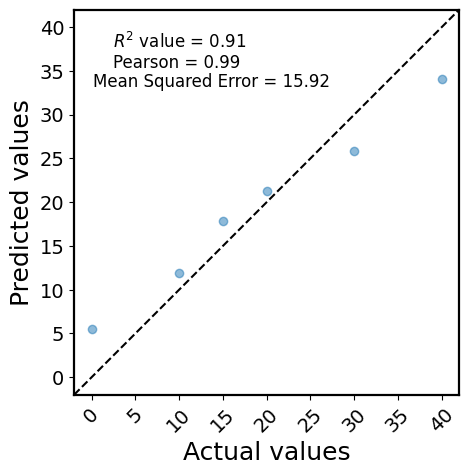

In [20]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

## Residuals (only for test dataset)

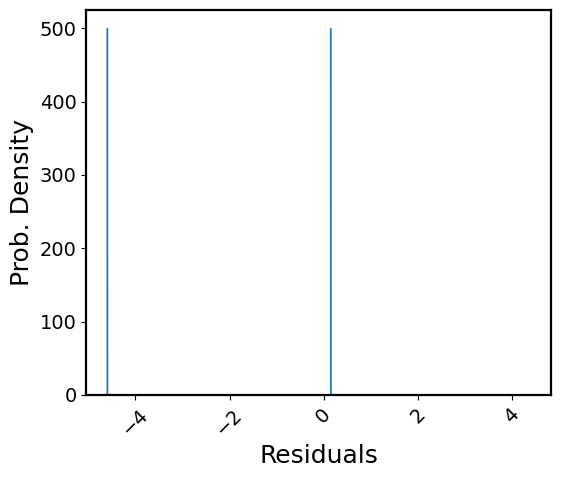

In [21]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.001),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)

In [22]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 66.16 %.


In [23]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

## Now running model 6 times each time using random train-test split


CPU times: user 19min 23s, sys: 2.09 s, total: 19min 26s
Wall time: 19min 29s


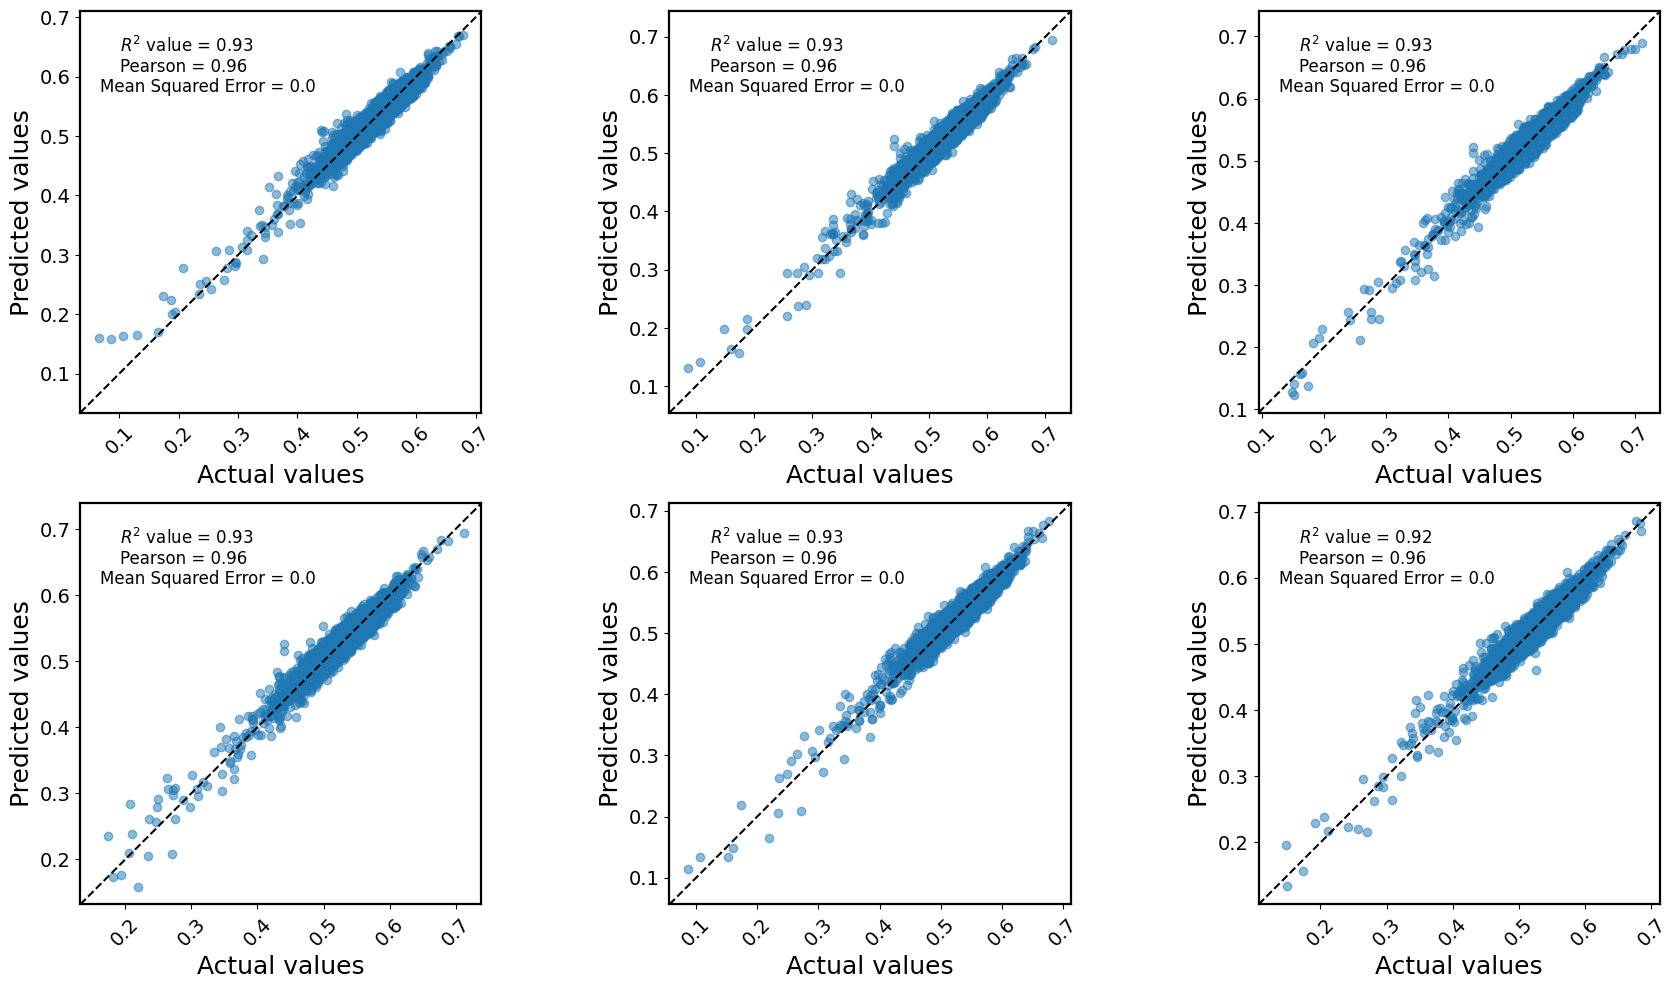

In [34]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [35]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors